# **Job Placement Predictor**

**Submitted by Group 33**  
- Ashmit Gupta  
- Jolin Lin  
- Shikha Rajesh  14573562
- Siddhanth Duggal  
- Yu Chang 47945050

**The University of British Columbia**  
**STAT 301**  
**Instructor**: Dr. Gabriela Cohen Freue  
**Date**: 2025/04/15


# 1. Introduction

Getting a job right after college is tough; even top students can struggle. One extra internship or club can make all the difference. We're exploring how academic records, internships, and extracurriculars can help predict job placement, building on findings by Kim et al. (2022) about factors linked to success.

Our primary goal and expectation is to answer the question: **How effectively can we develop a predictive model to classify a student’s placement status based on their relevant academic activities, performance metrics, and other associated scores?**

We're using prediction to find patterns in student data that could help guide job searches, using the tools and methods we've learned in STAT 301.

# 2. Methods and Results

### a) Data

#### Data Description 

*Entire text in this cell has been taken from Ashmit Gupta's Assignment 2*

The dataset contains various columns about the academic performance and the placement status (secured a job after graduation or not) of students. Notably, it has the following features:

- Number of variables: 12
- Number of observations: 10,000
- Variable Information: Included in the following table

| Column Name                  | Description                                                                                                                   | Data Type | Variable Type   |
|-----------------------------|-------------------------------------------------------------------------------------------------------------------------------|-----------|-----------------|
| `StudentID`                 | A unique identifier for each student (1 - 10000).                                                                             | double    | Categorical*    |
| `CGPA`                      | Overall cumulative grades achieved by a student (0 - 10 scale).                                                               | double    | Quantitative    |
| `Internships`               | Number of internships a student has completed.                                                                                | double    | Quantitative    |
| `Projects`                  | Number of projects a student has completed.                                                                                   | double    | Quantitative    |
| `Workshops/Certifications` | Number of online workshops/certifications a student has completed to upskill.                                                 | double    | Quantitative    |
| `AptitudeTestScore`         | A student's aptitude test score to gauge quantitative and logical thinking (0 - 100).                                         | double    | Quantitative    |
| `SoftSkillsRating`          | A student's communication/soft skill rating (1 - 5 scale).                                                                    | double    | Quantitative    |
| `ExtracurricularActivities` | Whether a student participates in extracurricular activities (Yes/No).                                                        | character | Categorical     |
| `PlacementTraining`         | Whether a student has undergone placement training to ace the placement process (Yes/No).                                     | character | Categorical     |
| `SSC_Marks`                 | A student's Senior Secondary Certificate marks (0 - 100).                                                                     | double    | Quantitative    |
| `HSC_Marks`                 | A student's Higher Secondary Certificate marks (0 - 100).                                                                     | double    | Quantitative    |
| `PlacementStatus`           | Placement outcome (target column with two classes: Placed/Not placed).                                                        | character | Categorical     |


 * Although StudentID is numeric in nature, it is categorical in this context.
 * *Entire table and text in it has been taken from Siddhanth Duggal's Assignment 1/2*


#### Data Source and Citation

*Entire text in this cell has been taken from Ashmit Gupta's Assignment 2*

The dataset has been taken from Kaggle (https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data) updated 2 months ago by Kaggle username 'ruchikakumbhar'. It is under the 'CC0: Public Domain' License so the Kaggle user does not endorse this dataset. This also means it is freely available for us to use. 

The data collection method is not provided in the author's profile nor on the Kaggle dataset webpage, so we would assume it's **observational data**. The citation is as follows:

Kumbhar, R. (n.d.). *Placement Prediction Dataset*. Kaggle. Retrieved from [https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data](https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data)

#### Data Loading

In [ ]:
#Loading Libs
library(dplyr)
library(car)
library(tidyverse)
library(gridExtra)
library(corrplot)
library(caret)
library(pROC)

In [22]:
# Main Developer: Yu Chang
# Entire code in this cell has been taken from Yu's Assignment 1
data_file_link <- "https://raw.githubusercontent.com/rainn72/Placement_predictor/refs/heads/main/data/placementdata.csv"
data <- read_csv(data_file_link, show_col_types = FALSE)

original_data <- data
num_observations <- nrow(data)
num_variables <- ncol(data)
cat("Number of observations:", num_observations, "\n")
cat("Number of variables:", num_variables, "\n")

Number of observations: 10000 
Number of variables: 12 


#### Initial Data Preprocessing

1. we checked if there're duplicated values in the dataset and there are no duplicates that we need to remove.

In [23]:
# Main Developer: Ashmit Gupta
# Entire code in this cell has been taken from Ashmit Gupta's Assignment 2

duplicate_values <- data %>% 
                    group_by(StudentID) %>% 
                    summarise(value_count = n()) %>%
                    filter(value_count > 1)
                    
duplicate_values

StudentID,value_count
<dbl>,<int>


*Entire text in this cell has been taken from Ashmit Gupta's Assignment 2*

2. We will drop the StudentID column since this variable definitely won't be useful in our prediction.


In [24]:
# Main Developer: Yu Chang
data <- data %>% select(-StudentID)

3. We changed the name of a covariate because it("/") may raise errors in some following code

In [25]:
# Main Developer: Yu Chang
data <- data %>%
  rename(Workshops_Certifications = `Workshops/Certifications`)

head(data, 3)


CGPA,Internships,Projects,Workshops_Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced


4. We replaced the levels `NotPlaced` and `Placed` for `PlacementStatus` in the dataset with the numerical values `1` and `0`

In [26]:
# Main Developer: Yu Chang
data <- data %>%
  mutate(PlacementStatus = if_else(PlacementStatus == "Placed", 1, 0))

data$PlacementStatus <- factor(data$PlacementStatus,
                                 levels = c("0", "1"))

5. Convert the Yes/No columns (categorical) to factors and later we will 0-1 encode them for interpretability, and we treat the covariates like `Internships` or `projects` as numeric, which assumes a linear effect between each 'level'.

In [27]:
# Main Developer: Yu Chang

data$ExtracurricularActivities <- factor(data$ExtracurricularActivities,
                                         levels = c("No", "Yes"))
data$PlacementTraining <- factor(data$PlacementTraining,
                                 levels = c("No", "Yes"))
head(data,3)

CGPA,Internships,Projects,Workshops_Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>
7.5,1,1,1,65,4.4,No,No,61,79,0
8.9,0,3,2,90,4.0,Yes,Yes,78,82,1
7.3,1,2,2,82,4.8,Yes,No,79,80,0


### b) Exploratory Data Analysis (EDA)

#### **Data Preprocessing**


##### **Check Missing Values**

In [28]:
# Main Developer: Yu Chang
colSums(is.na(data))

CGPA               Internships                  Projects 
                        0                         0                         0 
 Workshops_Certifications         AptitudeTestScore          SoftSkillsRating 
                        0                         0                         0 
ExtracurricularActivities         PlacementTraining                 SSC_Marks 
                        0                         0                         0 
                HSC_Marks           PlacementStatus 
                        0                         0

Good! The dataset contains no missing values.

##### **Check Class Imbalance**

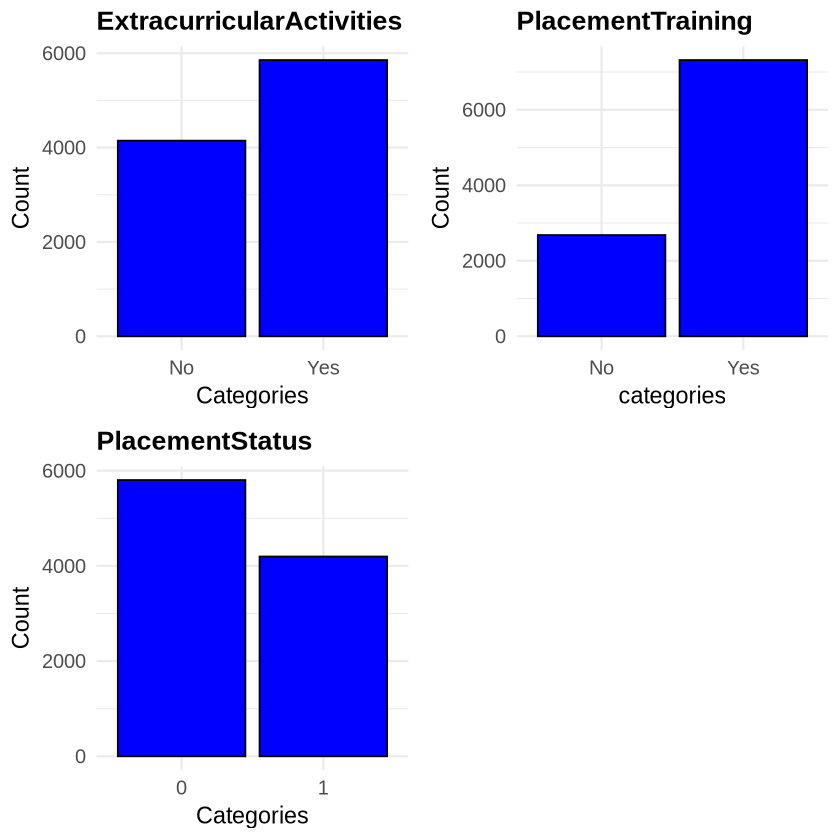

In [29]:
# Main Developer: Yu Chang

p1 <- ggplot(data, aes(x = ExtracurricularActivities)) +
  geom_bar(fill = "blue", color = "black") +
  labs(title = "ExtracurricularActivities", x = "Categories", y = "Count") +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12)
  )

p2 <- ggplot(data, aes(x = PlacementTraining)) +
  geom_bar(fill = "blue", color = "black") +
  labs(title = "PlacementTraining", x = "categories", y = "Count") +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12)
  )

p3 <- ggplot(data, aes(x = PlacementStatus)) +
  geom_bar(fill = "blue", color = "black") +
  labs(title = "PlacementStatus", x = "Categories", y = "Count") +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12)
  )

grid.arrange(p1, p2, p3, ncol = 2)

#Citation:   Auguie B (2017). _gridExtra: Miscellaneous Functions for "Grid"
  #Graphics_. R package version 2.3,
  #<https://CRAN.R-project.org/package=gridExtra>.

#Reason of using:  We found that simply call each plot object would make them displaying vertically,
# which isn't suitable for quick scaning, so we utilized the library gridExtra and the function grid.arrange()

*Entire text in this cell has been taken from Ashmit Gupta's Assignment 2*
- For the response variable (PlacementStatus), there is no class imbalance, so no further tidying is required in this aspect.
- There are enough values in both the categorical predictor variables for each of their categories such that there is no reason to merge or drop come categories.

##### **Check Distributional Skewness**

In [30]:
# Main Developer: Yu Chang
names(data)

[1] "CGPA"                      "Internships"              
 [3] "Projects"                  "Workshops_Certifications" 
 [5] "AptitudeTestScore"         "SoftSkillsRating"         
 [7] "ExtracurricularActivities" "PlacementTraining"        
 [9] "SSC_Marks"                 "HSC_Marks"                
[11] "PlacementStatus"

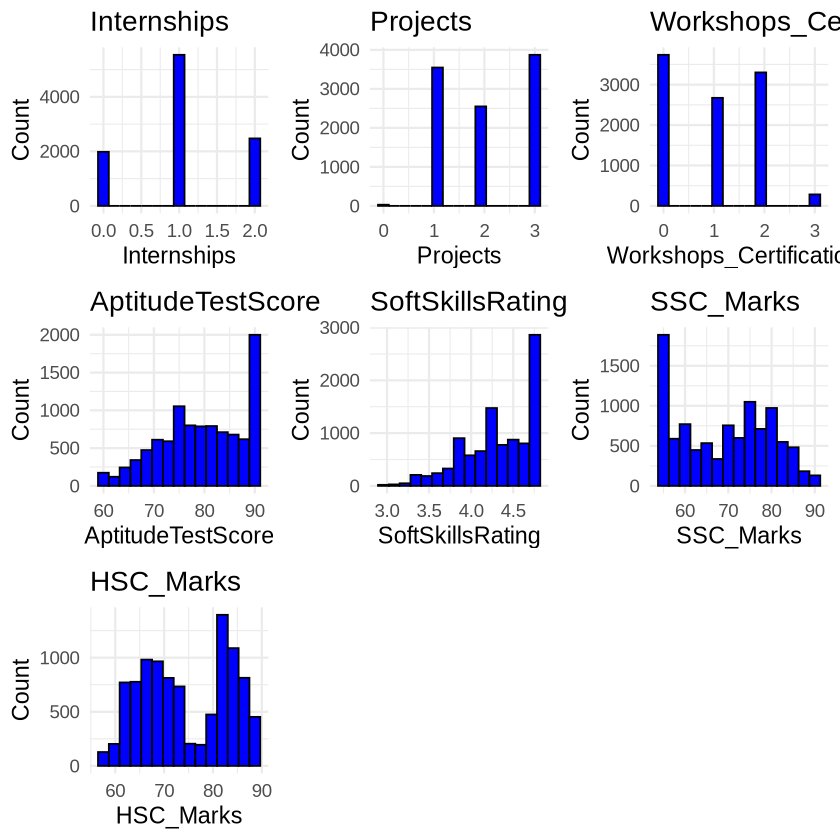

In [31]:
# Main Developer: Yu Chang
# p1: Internships
p1 <- ggplot(data, aes(x = Internships)) +
  geom_histogram(fill = "blue", color = "black", bins = 15) +
  labs(
    title = "Internships",
    x = "Internships",
    y = "Count"
  ) +
  theme_minimal(base_size = 14)

# p2: Projects
p2 <- ggplot(data, aes(x = Projects)) +
  geom_histogram(fill = "blue", color = "black", bins = 15) +
  labs(
    title = "Projects",
    x = "Projects",
    y = "Count"
  ) +
  theme_minimal(base_size = 14)

# p3: Workshops_Certifications
p3 <- ggplot(data, aes(x = Workshops_Certifications)) +
  geom_histogram(fill = "blue", color = "black", bins = 15) +
  labs(
    title = "Workshops_Certifications",
    x = "Workshops_Certifications",
    y = "Count"
  ) +
  theme_minimal(base_size = 14)

# p4: AptitudeTestScore
p4 <- ggplot(data, aes(x = AptitudeTestScore)) +
  geom_histogram(fill = "blue", color = "black", bins = 15) +
  labs(
    title = "AptitudeTestScore",
    x = "AptitudeTestScore",
    y = "Count"
  ) +
  theme_minimal(base_size = 14)

# p5: SoftSkillsRating
p5 <- ggplot(data, aes(x = SoftSkillsRating)) +
  geom_histogram(fill = "blue", color = "black", bins = 15) +
  labs(
    title = "SoftSkillsRating",
    x = "SoftSkillsRating",
    y = "Count"
  ) +
  theme_minimal(base_size = 14)

# p6: SSC_Marks
p6 <- ggplot(data, aes(x = SSC_Marks)) +
  geom_histogram(fill = "blue", color = "black", bins = 15) +
  labs(
    title = "SSC_Marks",
    x = "SSC_Marks",
    y = "Count"
  ) +
  theme_minimal(base_size = 14)

# p7: HSC_Marks
p7 <- ggplot(data, aes(x = HSC_Marks)) +
  geom_histogram(fill = "blue", color = "black", bins = 15) +
  labs(
    title = "HSC_Marks",
    x = "HSC_Marks",
    y = "Count"
  ) +
  theme_minimal(base_size = 14)

grid.arrange(p1, p2, p3, p4, p5, p6, p7, ncol = 3)


**Note: the number of students with Wrokshaops_Certifications experience = 3 and Project experience = 0 are clearly relatively low compared to other categories. So we check it here. The rest of the plots are looking fine right now.**

In [32]:
# Main Developer: Yu Chang
# First occurrence of the cat function that is also used later
# cat(): Package - base (no library needed; built-in with R)
cat("The Number of Students who have Workshop Experience = 3:", 
            sum(data$Workshops_Certifications == "3"),"\n")

cat("The Number of Students who have Workshop Experience = 2:", 
            sum(data$Workshops_Certifications == "2"),"\n")

cat("---------------------------------------------------------------","\n")

cat("The Number of Students who have Project number = 1:", 
            sum(data$Projects == "1"),"\n")

cat("The Number of Students who have Project number = 0:", 
            sum(data$Projects == "0"),"\n")

The Number of Students who have Workshop Experience = 3: 284 
The Number of Students who have Workshop Experience = 2: 3303 
--------------------------------------------------------------- 
The Number of Students who have Project number = 1: 3547 
The Number of Students who have Project number = 0: 30 


**Since there're clearly relative less people with workshop experience = 3 and Project experience = 0, so we will first merge them with the clostest category for now**. 

In [33]:
# Main Developer: Yu Chang

#Pre-process "Workshops"
data <- data %>%
  mutate(
    Workshops_Certifications = as_factor(Workshops_Certifications),
    Workshops_Certifications = fct_collapse(
      Workshops_Certifications,
      "2+" = c("2", "3")
    )
  )
#Pre-process "Projects"
data <- data %>%
  mutate(
    Projects = as_factor(Projects),
    Projects = fct_collapse(
      Projects,
      "1-" = c("0", "1")
    )
  )

head(data, 3)

CGPA,Internships,Projects,Workshops_Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>
7.5,1,1-,1,65,4.4,No,No,61,79,0
8.9,0,3,2+,90,4.0,Yes,Yes,78,82,1
7.3,1,2,2+,82,4.8,Yes,No,79,80,0


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


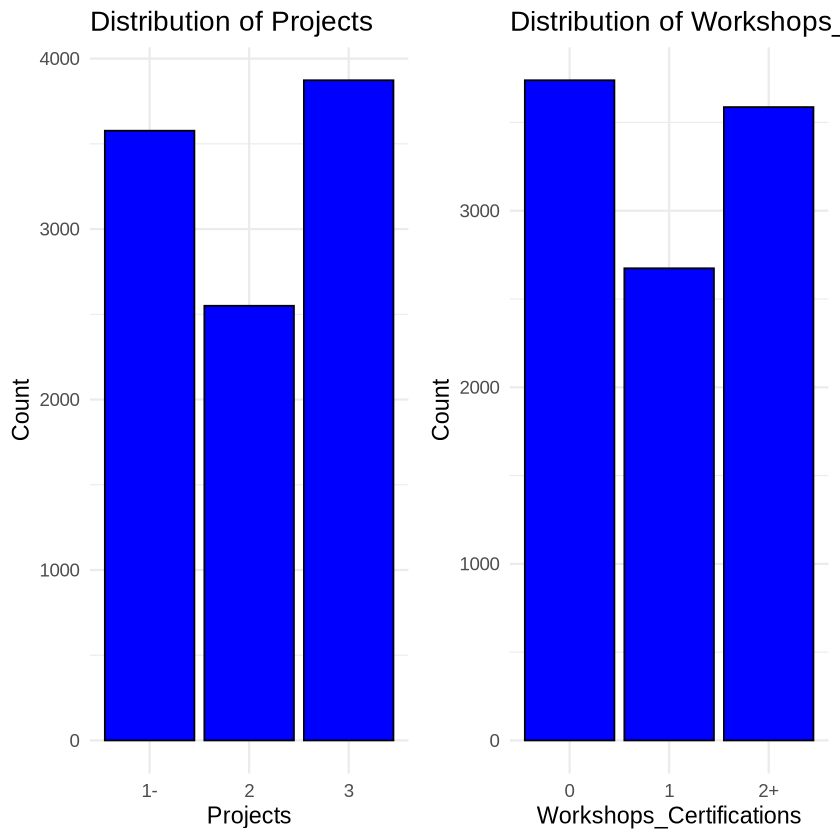

In [34]:
# credit goes to Yu Chang
plots <- list()

p <- ggplot(data, aes_string(x = "Projects")) +
    geom_bar(fill = "blue", color = "black") + 
    labs(
      title = paste("Distribution of Projects"),
      x = "Projects",
      y = "Count"
    ) +
    theme_minimal(base_size = 14)
  plots[["Projects"]] <- p

  p <- ggplot(data, aes_string(x = "Workshops_Certifications")) +
    geom_bar(fill = "blue", color = "black") + 
    labs(
      title = paste("Distribution of Workshops_Certifications"),
      x = "Workshops_Certifications",
      y = "Count"
    ) +
    theme_minimal(base_size = 14)
  plots[["Workshops_Certifications"]] <- p

  
grid.arrange(grobs = plots, ncol = 2)


##### **Two Effective Visualizations**
##### **1.Comparison of various scores of students by placement status**

*Entire text in this cell has been taken from Ashmit Gupta's Assignment 2*
- We will create a boxplot of the numerical covariates (CGPA, HSC_Marks, SSC_Marks, AptitudeTestScore, SoftSkillsRating)
- This, notably, excludes 3 numerical columns: `Internships`, `Project`s and `Workshops/Certifications`. This is because these columns have only descretised values, which are 0, 1, 2 or 3. Hence, their range, standard deviation and mean would differ a lot from the other numerical variables and thus won't look well on a single plot. Maybe in the future, we could even convert these column into 'factor' type (categorical variables) if it leads to better prediction.
- For the visualisation now, we will scale CGPA and SoftSkillsRating to be on the same scale
  - We will multiply CGPA by 10 to shift its range from 0-10 to 0-100
   - We will multiply SoftSkillsRating by 20 to shift its range 0-5 to 0-100 <br> This is done so a good comparison can be made visually by just looking at the plot.

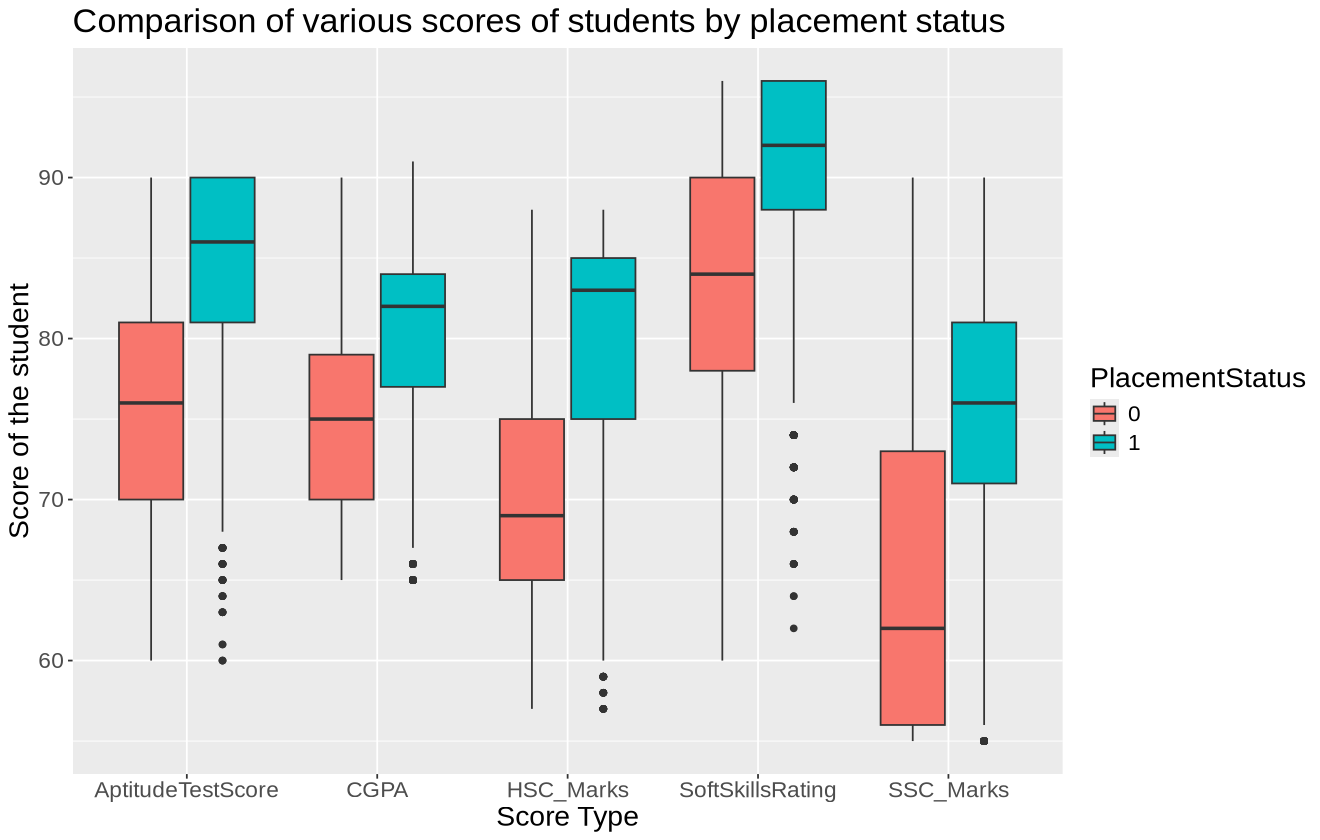

In [35]:
# Main developer: Ashmit Gupta
# Entire code and comments in this cell taken from Ashmit Gupta's Assignment 2

options(repr.plot.width = 11, repr.plot.height = 7)
marks_data <- data %>%
              mutate(CGPA = CGPA * 10, SoftSkillsRating = SoftSkillsRating * 20) %>% # Scaling CGPA and SoftSkillsRating to be from 1 to 100
              pivot_longer(cols = c(CGPA, HSC_Marks, SSC_Marks, AptitudeTestScore, SoftSkillsRating), 
                           names_to = "Score_Type", 
                           values_to = "Score")

marks_visualisation <- marks_data %>%
                       ggplot(aes(x = Score_Type, y = Score, fill = PlacementStatus)) +
                       geom_boxplot() +
                       ggtitle("Comparison of various scores of students by placement status") +
                       labs(x = "Score Type", y = "Score of the student") +
                       theme(text = element_text(size = 17))
                       
marks_visualisation

*Entire text in this cell has been taken from Ashmit Gupta's Assignment 2*

This graph is relevant to our research question as it shows the distribution of various possible predictors against the response variable (PlacementStatus). It shows that in general, the students who are placed tend to have a higher median score in the respective academic (or soft skill) category compared to the students who did not get placed.


##### **2. Check and Visualize Correlation between Features**

To detect whether there's a multicollinearlity issue in the independent variables, we examine it by both the correlation matrix and the variance inflation factor (VIF). 

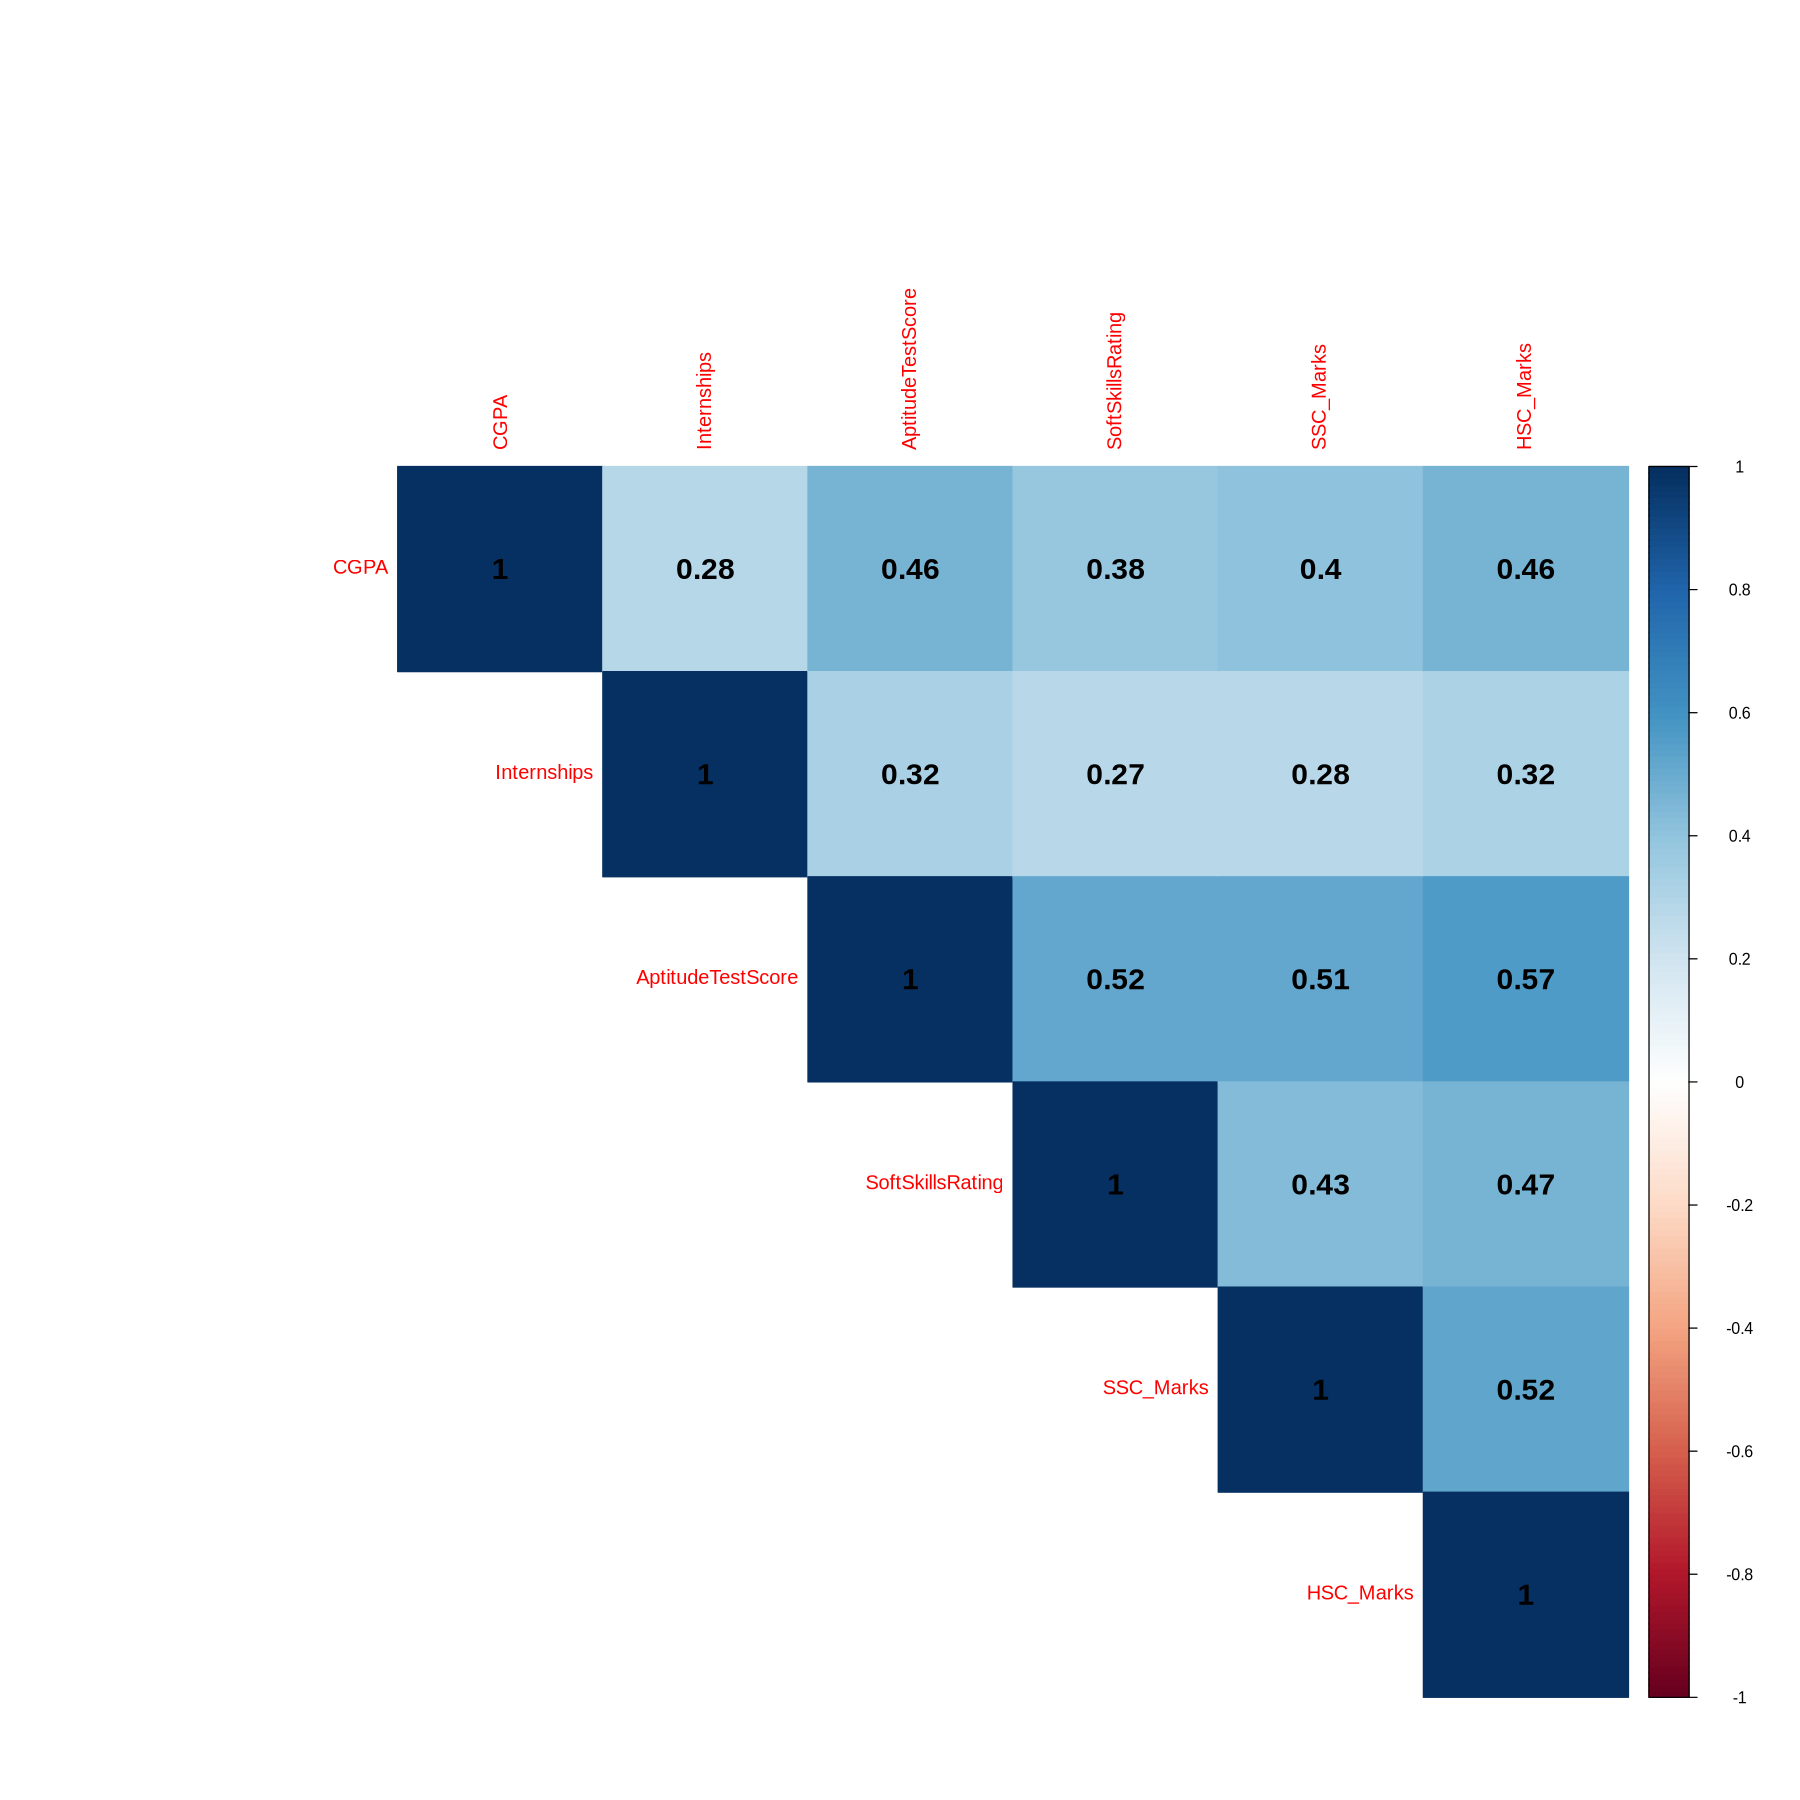

In [45]:
# Main Developer: Yu Chang
options(repr.plot.width = 15, repr.plot.height = 15)

numeric_data <- data %>% select_if(is.numeric)
cor_matrix <- cor(numeric_data)

corrplot(cor_matrix,
         method = "color",
         type = "upper",
         addCoef.col = "black",
         number.cex = 1.5
)
# Package: corrplot, Library: corrplot
# To visualize the correlation matrix between numeric features with color-coded strength of associations.

The correlation matrix heatmap indicates all pairs in continuous variables have a positive relationship, moreover, the correlation coefficient between any two pairs are lower than 0.6, suggesting no strong correlation. Therefore, multicollinearlity issue is not concerning at this stage.

Next, we will use VIF to detect whether multicollinearlity issue exist among both continuous and categorical independent variables. 

,GVIF,Df,GVIF^(1/(2*Df))
CGPA,1.232387,1,1.110129
Internships,1.128324,1,1.062226
Projects,1.400640,2,1.087882
Workshops_Certifications,1.265626,2,1.060660
AptitudeTestScore,1.401241,1,1.183740
SoftSkillsRating,1.252753,1,1.119264
ExtracurricularActivities,1.284762,1,1.133473
PlacementTraining,1.031981,1,1.015865
SSC_Marks,1.316573,1,1.147420
HSC_Marks,1.462161,1,1.209198


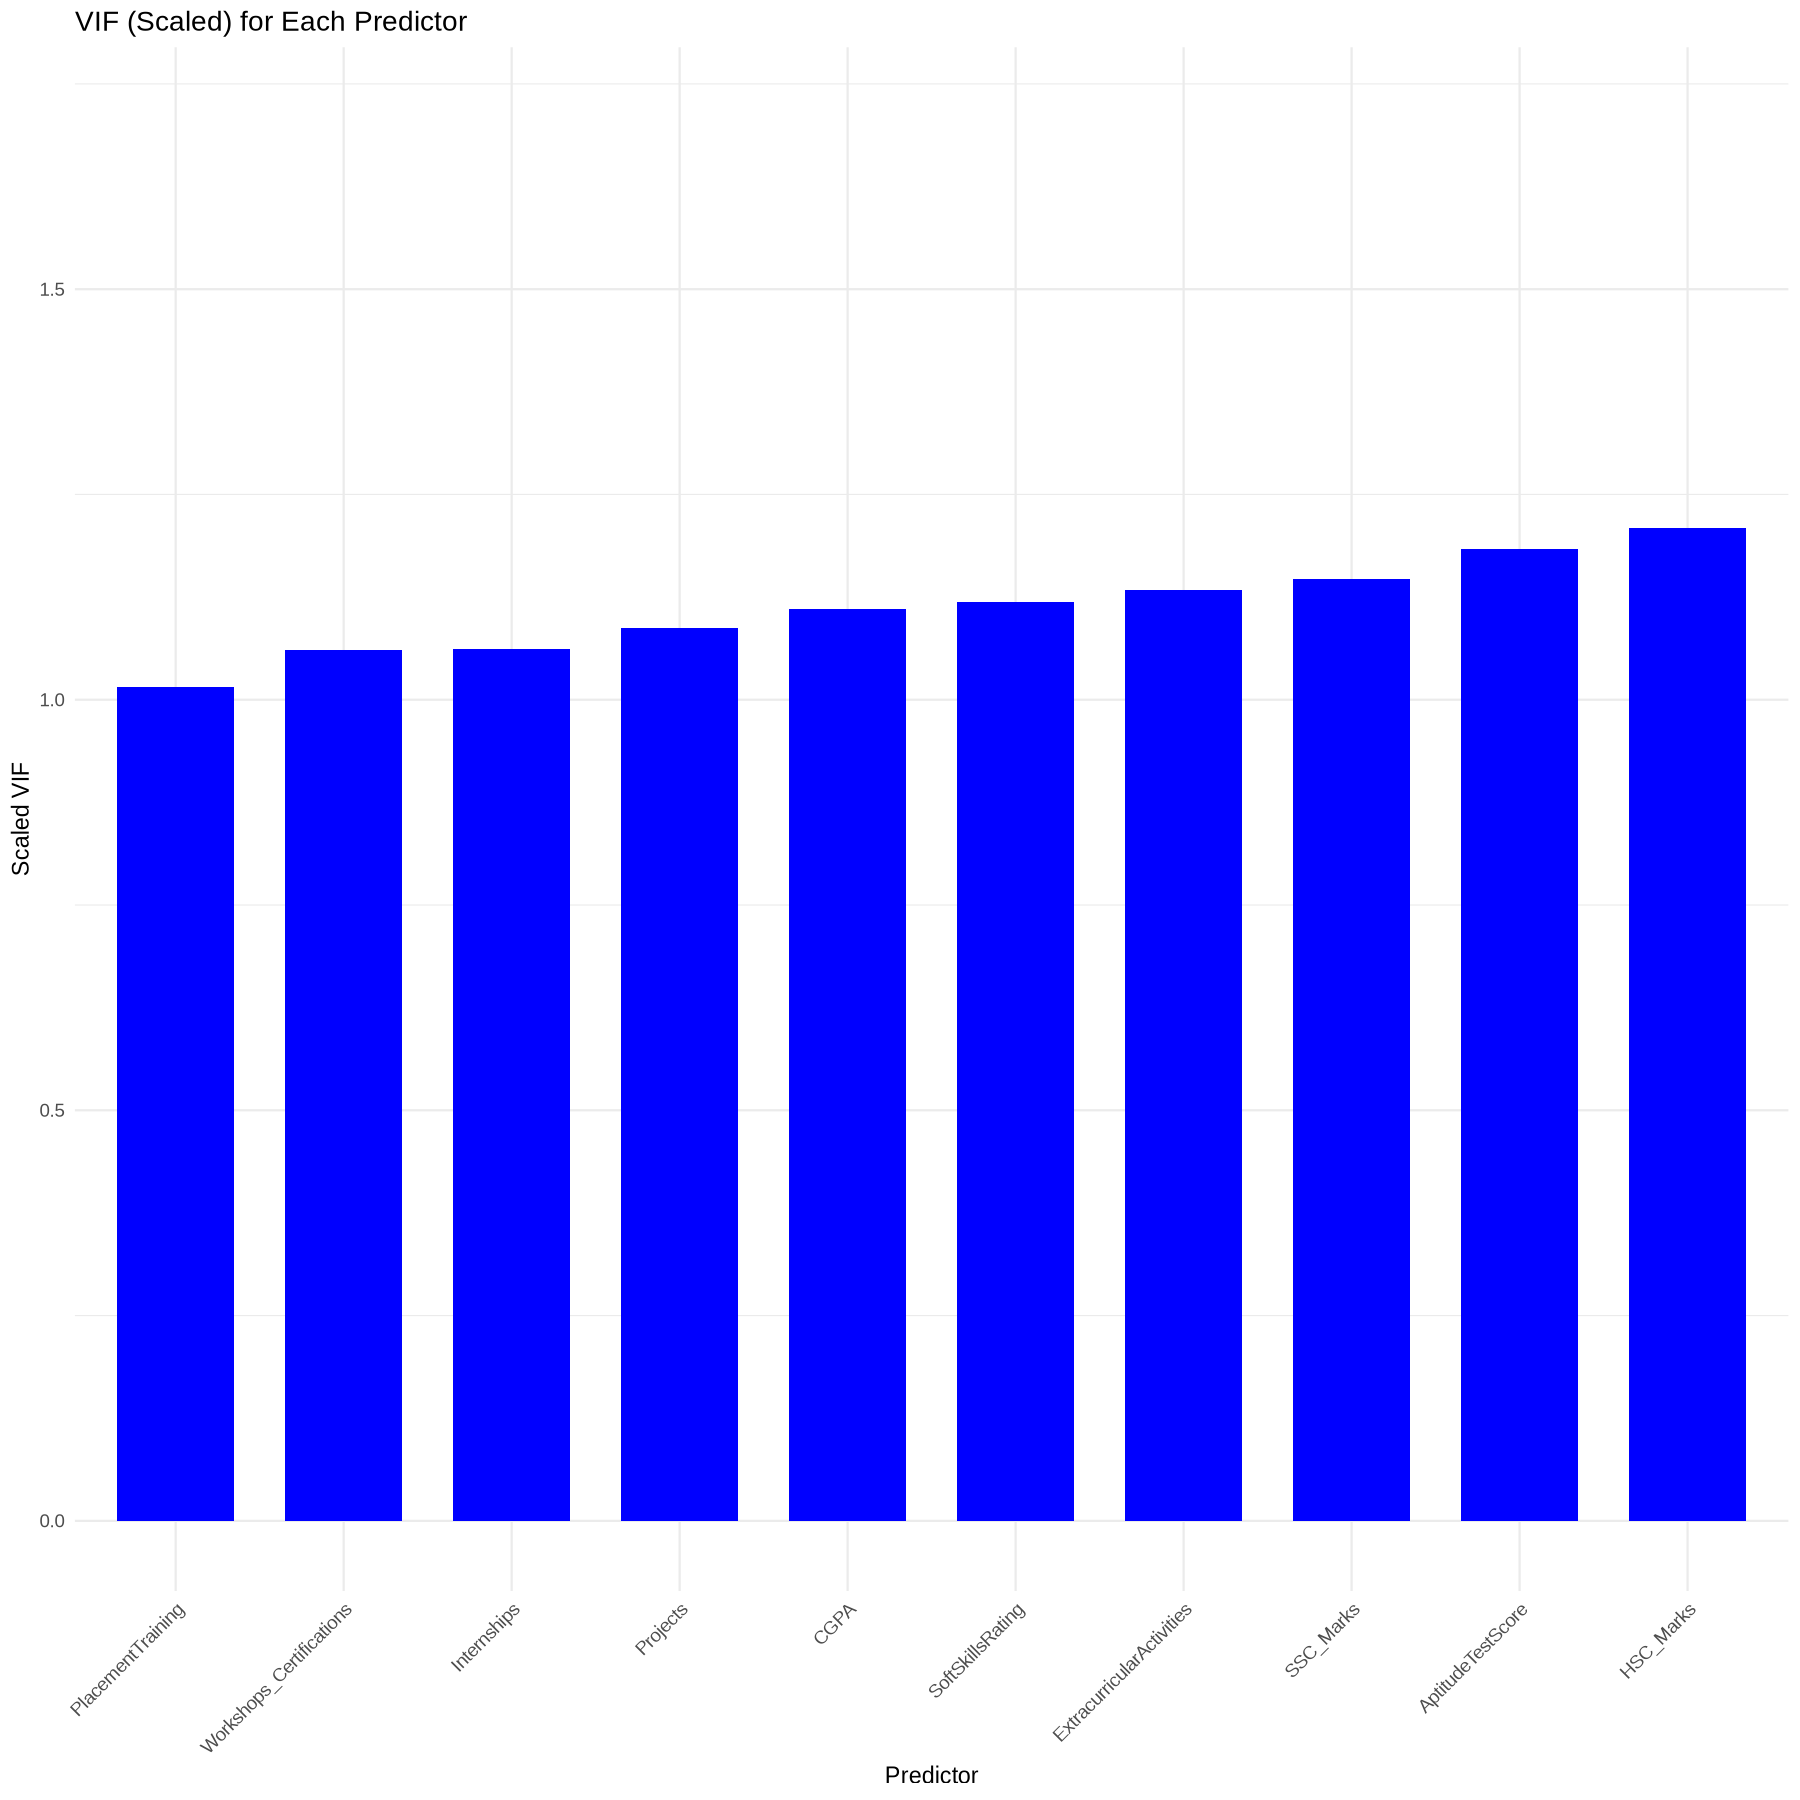

In [50]:
# Main developer: Jolin Lin
# Contributor: Shikha (Plotting the bar plot - Steps 5 & 6)

vif_data <- data %>%
  mutate(ExtracurricularActivities = if_else(ExtracurricularActivities == "Yes", 1, 0),
         PlacementTraining  = if_else(PlacementTraining  == "Yes", 1, 0))

# 2) Fit logistic model
model_vif <- glm(PlacementStatus ~ ., data = vif_data, family = "binomial")

# 3) Compute VIF
vif_res <- vif(model_vif)

vif_res

# 4) Extract the scaled GVIF from output
scaled_vif <- vif_res[, "GVIF^(1/(2*Df))"]

# 5) Create dataframe for plotting
vif_df <- data.frame(
  Predictor = names(scaled_vif),
  VIF_Scaled = as.numeric(scaled_vif)
)

# 6) Create VIF barplot
ggplot(vif_df, aes(x = reorder(Predictor, VIF_Scaled), y = VIF_Scaled)) +
  geom_col(fill = "blue", width = 0.7) +
  labs(
    title = "VIF (Scaled) for Each Predictor",
    x = "Predictor",
    y = "Scaled VIF"
  ) +
  ylim(0, max(vif_df$VIF_Scaled) + 0.5) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )


The VIF value for each variable are all just slightly higher than 1, suggesting a low correlation between predictor variables based on the rules of thumb of VIF (GVIF ~= 1 indicating little to no multicollinearity). 

This is a more formal way to check and visualize the result concluded by correlation matrix, Generalized VIF suggests multicollinearlity issue is not concerning at this stage.

*Entire text in this cell has been taken from Ashmit Gupta's Assignment 2*
## Methods and Plan
- **Method:** Logistic Regression (Additive model)
- **Reason:** 
    - Logistic regression model is used when the response variable is binary and binomial. In our case, the response variable is also binary and binomial since it has only 2 possible values 'placed' or 'not placed'.
    - It can also be used as a classifier to predict the probability of the response variable leading to very interpretable and quantifiable results. Since our research question is based on 'prediction', this would be really helpful.
    - We chose an additive model, and not a model with interaction terms, because an additive model looks at how each variable is related to the response individually, while keeping all other variables constant. This will help our goal of finding good predictors and will greatly improve interpretability. 
- **Assumptions:**
    - Since we will be using an additive model, we are assuming that each variable has an individual association with the response variable and is not affected by the value of other variables.
- **Limitations:**
    - If the relation between response variable and log-odds of covariates is non-linear, the model results won't be good.
    - An additive model does not include any interaction terms so if there is some interaction between covariates, this would completely ignore it and thus might lead to an oversimplified model. 

#### **Feature Selection**

For predictive modeling best practices, we will split the data and do cross-validation to avoid overfitting and to better estimate out-of-sample performance.

In [51]:
# 1) Split data into train & test sets
# credit goes to Yu Chang
# *Entire code in this cell has been taken from Yu Chang's Assignment 2*
set.seed(123)
train_index <- sample(seq_len(nrow(data)), size = 0.7 * nrow(data))
train_data  <- data[train_index, ]
test_data   <- data[-train_index, ]

head(train_data)

CGPA,Internships,Projects,Workshops_Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>
7.9,0,1-,0,64,4.1,Yes,Yes,63,67,0
8.2,2,3,2+,87,4.8,Yes,Yes,77,86,1
7.3,0,1-,0,72,4.3,No,No,55,68,0
6.8,1,1-,1,84,4.2,No,No,55,69,0
7.3,0,1-,1,74,3.8,No,Yes,60,65,0
7.9,0,2,0,75,4.3,No,No,79,63,0


In [52]:
# Main Developer: Shikha
library(MASS)

# 1) Fit the full logistic model (using training data)
full_model <- glm(PlacementStatus ~ ., data = train_data, family = "binomial")

# 2) Apply stepwise selection using AIC (backward by default)
model_stepAIC <- stepAIC(full_model, direction = "both", trace = FALSE)

# 3) View the summary of the final model
summary(model_stepAIC)


Call:
glm(formula = PlacementStatus ~ CGPA + Projects + Workshops_Certifications + 
    AptitudeTestScore + SoftSkillsRating + ExtracurricularActivities + 
    PlacementTraining + SSC_Marks + HSC_Marks, family = "binomial", 
    data = train_data)

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -16.440476   0.657634 -24.999  < 2e-16 ***
CGPA                           0.352759   0.059739   5.905 3.53e-09 ***
Projects2                      0.165889   0.088103   1.883   0.0597 .  
Projects3                      0.549776   0.090872   6.050 1.45e-09 ***
Workshops_Certifications1     -0.375203   0.086352  -4.345 1.39e-05 ***
Workshops_Certifications2+     0.347914   0.080981   4.296 1.74e-05 ***
AptitudeTestScore              0.068917   0.005680  12.133  < 2e-16 ***
SoftSkillsRating               0.621913   0.100498   6.188 6.08e-10 ***
ExtracurricularActivitiesYes   0.793732   0.081300   9.763  < 2e-16 ***
PlacementTrainin

**How the test data created and used :**

* We manually split the train and test data. We run a stepwise logistic regression to choose covariates (based on AIC).
* Note that we kept the test data locked and it wasn't used in fitting or selecting the model, only for final evaluation.

**A brief Interpretation of the results:**

Note that in the summary output of the logistic regression model, the covariate **Internships** was not selected (dropped) by StepAIC, indicating that it may have little predictive effect on the response variable. Also for the covariates Projects2, its p value was a little bit above the traditional significance level 0.05, but we think its predicting power remains effective.

**Performing a careful model assessment and showing visualizations**

1. Model Performance Table

In [53]:
# Main Developer: Yu Chang
# Prediction and Reporting 
# Entire code and comments in this cell taken from Yu Chang's Assignment 2
test_probs  <- predict(model_stepAIC, newdata = test_data, type = "response")
test_class   <- ifelse(test_probs > 0.5, "1", "0")

# Convert and ensure both predicted and actual are factors with matching levels 0,1
test_pred_factor <- factor(test_class, levels = c(0,1))
test_out_factor  <- factor(test_data$PlacementStatus, levels = c(0,1))

#Confusion Matrix
conf_mat <- confusionMatrix(test_pred_factor, test_out_factor)
conf_mat


Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1460  314
         1  291  935
                                          
               Accuracy : 0.7983          
                 95% CI : (0.7835, 0.8126)
    No Information Rate : 0.5837          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.5839          
                                          
 Mcnemar's Test P-Value : 0.3711          
                                          
            Sensitivity : 0.8338          
            Specificity : 0.7486          
         Pos Pred Value : 0.8230          
         Neg Pred Value : 0.7626          
             Prevalence : 0.5837          
         Detection Rate : 0.4867          
   Detection Prevalence : 0.5913          
      Balanced Accuracy : 0.7912          
                                          
       'Positive' Class : 0               
                        

Based on the confusion matrix and accompanying statistics, the logistic regression model achieves approximately **79.83%** accuracy, meaning it correctly distinguishes “Placed” versus “Not Placed” students most of the time!

Its Sensitivity (about **83%**) implies that the model accurately identifies a high proportion of students who are truly placed, and a Specificity near **75%** indicates that our model does a fair job of minimizing false positives. Overall, these metrics suggest a reasonably balanced performance in predicting placement outcomes, though there may still be room for fine‐tuning or additional feature engineering to further improve results.

2. Check ROC

Setting direction: controls < cases



Area under the curve: 0.8769

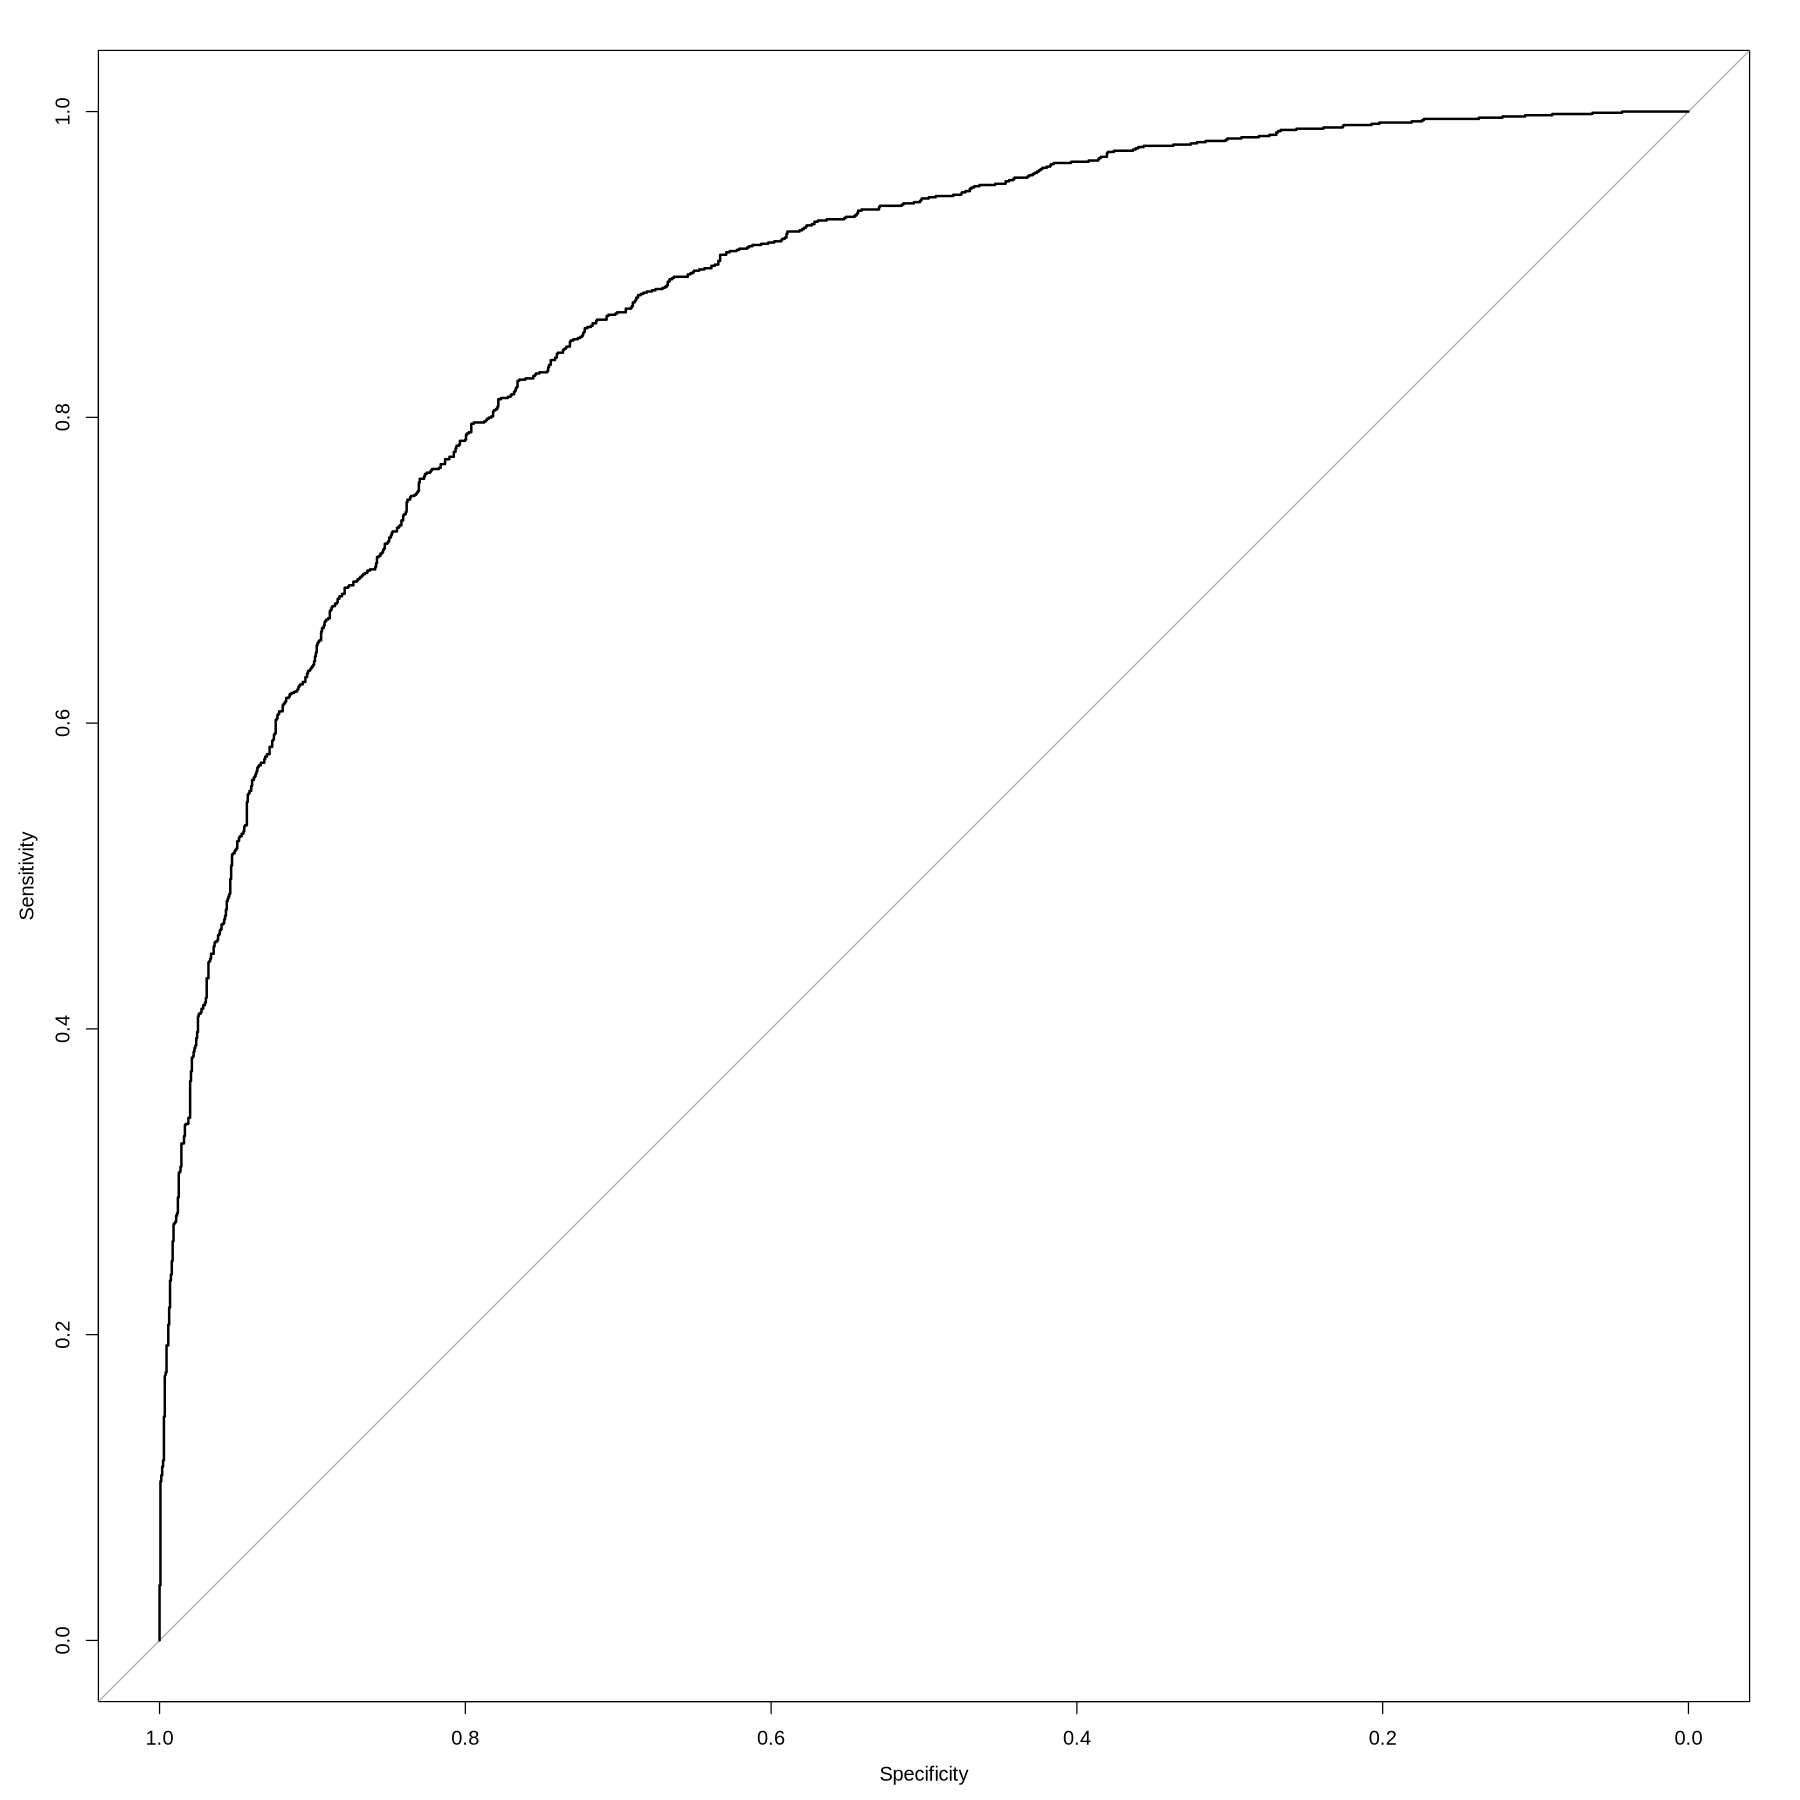

In [54]:
# Main Developer: Yu Chang
roc_obj <- roc(response = test_data$PlacementStatus,
               predictor = test_probs,
               levels = c("0","1"))
auc_val <- auc(roc_obj)
plot(roc_obj)


auc_val


This ROC curve shows how well our model can tell the difference between placed and not placed students. With an AUC (Area Under the Curve) of 0.88, the curve hugs the top-left corner, meaning the model performs very well across different threshold values. In simple terms, it’s good at ranking students by their likelihood of getting placed—even beyond just a 0.5 cut-off.

3. Test Set Accuracy

In [60]:
#Main Developer: Shikha
test_probs <- predict(model_stepAIC, newdata = test_data, type = "response")
test_pred <- ifelse(test_probs > 0.5, 1, 0)
test_pred_factor <- factor(test_pred, levels = c(0, 1))
test_out_factor  <- factor(test_data$PlacementStatus, levels = c(0, 1))

conf_mat <- confusionMatrix(test_pred_factor, test_out_factor)
test_accuracy <- conf_mat$overall["Accuracy"]

cat("Test Set Accuracy:", round(test_accuracy, 4), "\n")

Test Set Accuracy: 0.7983 


We used AIC-based stepwise logistic regression to fit the model and evaluated its predictive performance using the test set. The model has a test accuracy of 79.83%, indicating strong generalization on unseen data.

# 3. Discussion


Our primary goal was to evaluate how well a logistic regression model can predict student placement status using academic scores, co-curricular activities, and training indicators. The final model achieved a test set accuracy of 79.83%, indicating strong generalization performance and reliable predictive power on unseen data. This is further supported by the ROC AUC of 0.877, indicating strong discriminative power.

**Key Findings & Implications**
The most impactful predictors based on model coefficients include:

- PlacementTrainingYes (β = 0.96) and ExtracurricularActivitiesYes (β = 0.79), highlighting the real-world value of training and non-academic development.

- AptitudeTestScore (β = 0.07), SoftSkillsRating (β = 0.62), and CGPA (β = 0.35) are all statistically significant (p < 0.001), aligning with expectations that stronger academic and aptitude performance increases placement likelihood.

- Participation in Projects (especially Projects3, β = 0.55) and Workshops_Certifications also show meaningful positive associations.

These findings imply that holistic student development, not just academic achievement, plays a major role in employability. Institutions may leverage this insight to encourage project-based learning and soft skill training.
However, while the model predicts well, it is essential to recognize that these relationships are associational, not causal. For instance, students who undergo placement training may already be more motivated or better prepared. Thus, we cannot conclude that training *causes* placement success.

**Expectations vs. Results**
The results closely align with expectations: academic performance (CGPA), aptitude (AptitudeTestScore), and interpersonal ability (SoftSkillsRating) were anticipated to be strong predictors. Notably, PlacementTraining emerged as the most influential categorical variable, reinforcing the importance of structured preparation programs.

Interestingly, Internships was dropped during stepwise feature selection due to a lack of statistical contribution (∆AIC ≈ -25). This may reflect low variability or limited effect in this dataset.

**Model Improvement Opportunities**
While performance metrics are strong, the model could be refined in the following ways:

- The right-skewed AptitudeTestScore, especially a peak at 90, suggests potential bias. Binning or transforming this variable may improve fit and meet linearity assumptions.

- Testing non-linear models could help capture interactions and non-additive effects that logistic regression may miss.

- The current probability threshold (0.5) could be adjusted to better balance sensitivity (83%) and specificity (75%), depending on whether minimizing false positives or false negatives is more important to the people interested.

**Future Research Directions**
- Use causal inference techniques to better understand the true effect of factors like PlacementTraining.

- Include institution-level data (e.g., college rank, company connections) to expand the model’s generalizability.

- Investigate interaction effects, such as whether the benefit of soft skills or certifications is amplified when paired with training.

# 4. References
- Dataset has downloaded from Kaggle (https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data)
- All the information (like data description, number of variables, number of observations, variable name, variable type and variable description) in the main 'Data Description' section has been adapted from https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data
- Kim, J., Oh, J., & Rajaguru, Y. (2022). Job-seeking anxiety and job preparation behavior of undergraduate students. Healthcare, 10(2), 288. https://doi.org/10.3390/healthcare10020288

For Functions:
- R Core Team. (2024). *R: A language and environment for statistical computing (Version 4.3.3)*. R Foundation for Statistical Computing. [Computer software]. https://www.r-project.org/